# Data Wrangling and Analysis on twitter data

The aim of this project is to gather, access and clean data, to create reliable analysis. The data for this project is the tweet archive of  `@dog_rates`, also known as `WeRateDogs`. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog.

The initial WeRateDogs twitter archive doesn't contain all the required information/variables for this project. Such variables include `number of retweet`, `number of likes`. This variables are very important for this analysis, hence I'll be using the Twitter API to query this additional information

Additionally, an `image_prediction.txt`  file has been provided. The content is the result from a neural network that can classify breeds of dogs.The file is full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images). This file would be downloaded programmatically

Therefore, the aim is to gather these and convert it into a high-quality data, reliable for analysis

## Table of Contents
- Gathering data
- Accessing data
- Cleaning data
- Storing data
- Analyzing data
- Reporting

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy
import requests
import os
import json
import sys
module_path = r'C:\Users\Smart\Desktop\my_custom_scripts'
sys.path.insert(1, module_path)

import warnings
warnings.filterwarnings('ignore')

import plot_script
%matplotlib inline

## Gathering data

The project is based on three datasets
- `twitter-archive.txt` : Which contains the WeRateDogs Twitter archive of basic tweet data for all 5000+ of their tweets, but not everything. This datasset is already provided

- `image-prediction.txt` : The results: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images). This dataset would be downloaded programatically

- `additional data from twitter API` : The tweepy library would be used to query additional information which wasn't included in the `twitter-archive.txt` file

In [2]:
#read the weRateDog twitter achive into pandas dataframe
we_rate_dogs_data = pd.read_csv('./data/twitter-archive-enhanced.csv')

In [3]:
we_rate_dogs_data.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [4]:
%%perl -e0
#download the tweet image prediction file
path = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
root_folder = 'data'

#make a get request 
response = requests.get(path)

#create root folder if it doesn't exist
if not os.path.exists(root_folder):
    os.makedirs(root_folder)
    
#save the content of the response in the root folder
with open(os.path.join(root_folder, path.split('/')[-1]), 'wb') as file:
    file.write(response.content)

Couldn't find program: 'perl'


In [5]:
#read the image_prediction data into pandas dataframe
img_prediction = pd.read_csv('./data/image-predictions.tsv', sep='\t')

In [6]:
img_prediction.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


In [7]:
#download the additional using the tweepy library and Twitter API

#initialize access tokens

consumer_key = os.environ.get('twitter_consumer_api_key')
consumer_secret = os.environ.get('twitter_consumer_api_key_secrete')
access_token = os.environ.get('twitter_access_token')
access_secret = os.environ.get('twitter_access_token_secrete')

#create a tweepy authenticator object
authenticator = tweepy.OAuthHandler(consumer_key, consumer_secret)
authenticator.set_access_token(access_token, access_secret)

#create a tweepy_api object
the_api = tweepy.API(authenticator)

In [8]:
%%perl -e0
#Gather each tweet's retweet count and favorite ("like") count

#initialize filename for which the json object for each tweet would be appended
file_name = 'tweet_json_2.txt'

#delete the content of the file if it contains any text
# if os.stat('./data/tweet_json.txt').st_size != 0:
#     with open(os.path.join(root_folder, file_name), 'r+') as file:
#             file.truncate(0)
        
#get all ids
# tweet_id = we_rate_dogs_data['tweet_id'].values
tweet_id = we_rate_dogs_data.set_index('tweet_id').loc[758740312047005698 : , :].index

#get the total ids: this would help in tracking our query when running
total_tweet_count = len(tweet_id) -1

#for each tweet id, query the tweet and get the favorite count and retweet count
#save this data in a dictionary for each tweet_id
for id in tweet_id:
    #create a new dictionary-data for each tweet
    tweet_json_data = {
        'tweet_id' : str(id)
    }
    try:
        #query
        response = the_api.get_status(str(id), tweet_mode = 'extended')
        
        #save the tweet object in the dictionary
        tweet_json_data['retweet_count'] = str(response.retweet_count)
        tweet_json_data['favorite_count'] = str(response.favorite_count)
        
        #if error occurs, handle it
    except tweepy.TweepyException as error:
        tweet_json_data['retweet_count'] = str(error)
        tweet_json_data['retweet_count'] = str(error)
    
    #open the text file in append mode and append the tweet object data
    with open(os.path.join(root_folder, file_name), 'a') as file:
        file.write(json.dumps(tweet_json_data) + '\n')
    print('done... ' + str(total_tweet_count) + ' remaining', end='\r')
    total_tweet_count = total_tweet_count - 1

Couldn't find program: 'perl'


In [9]:
#read the json data into pandas dataframe
data_list =[]

with open('./data/tweet_json.txt', 'r') as file:
    data_line = file.read()
    data_list.append(data_line)

ok = map(lambda x: eval(x.split('\n')[0]), data_list[0].split('\n')) 
json_api_data = pd.DataFrame(list(ok))

In [10]:
json_api_data

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7009,33820
1,892177421306343426,5302,29337
2,891815181378084864,3481,22060
3,891689557279858688,7227,36947
4,891327558926688256,7763,35277
...,...,...,...
2351,666049248165822465,37,89
2352,666044226329800704,115,247
2353,666033412701032449,36,100
2354,666029285002620928,39,112


## Assessing Data

The three dataset required for this project is ready for assessing post... cleaning. In this section I'll take a visual and programmatic assessment on the three dataset for `Quality` and `Tidyness` issues. Each issue identified in the dataset would be documented. This would serve as a guild for the next section when cleaning the data.

In [11]:
we_rate_dogs_data.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [12]:
#check for basic info. about the data
we_rate_dogs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

<AxesSubplot:>

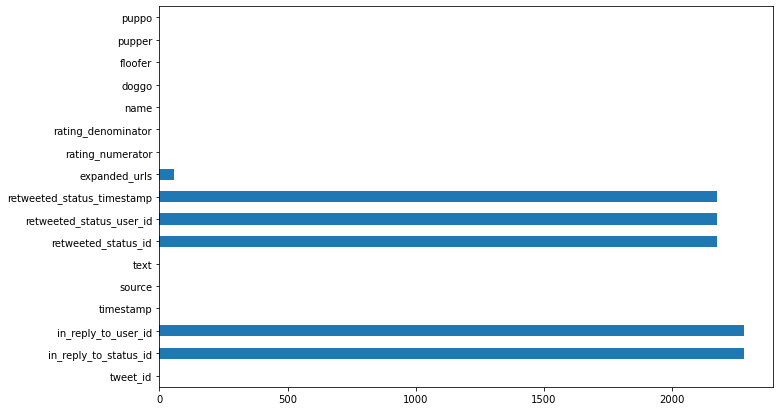

In [13]:
#check for null values
we_rate_dogs_data.isnull().sum().plot(kind='barh', figsize=(11, 7))

In [14]:
we_rate_dogs_data.duplicated().sum()

0

In [15]:
we_rate_dogs_data.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


### **Quality issues:**
- #### we_rate_dogs_data:
    - NaN values in columns: 
        - `in_reply_status_id`
        - `retweeted_status_id,`
        - `retweetwed_status_time_stamp` etc
    - timestamp column should be in pandas datetime format
    - columns not needed for this analysis include:
        - `source`
        - `timestamp` 
        - `expanded_urls`
        - `in_reply_status_id`
        - `retweeted_status_id`, 
        - `retweetwed_status_time_stamp`
    - maximum `rating_numerator` and `rating_denominator` is 1776 and 170 respectively. This is very far from 75% of other ratings

In [16]:
img_prediction.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
223,670303360680108032,https://pbs.twimg.com/media/CU1lWFaVAAAl0HG.jpg,1,Shetland_sheepdog,0.380278,True,Cardigan,0.342806,True,guinea_pig,0.156249,False
984,707420581654872064,https://pbs.twimg.com/media/CdFDQVgWIAArslx.jpg,1,ram,0.518215,False,kuvasz,0.149391,True,Great_Pyrenees,0.106003,True
281,671122204919246848,https://pbs.twimg.com/media/CVBOFTLWwAAzlNi.jpg,1,goose,0.351957,False,Chihuahua,0.101228,True,hen,0.065818,False
1595,798925684722855936,https://pbs.twimg.com/media/CxZaqh_WQAA7lY3.jpg,1,West_Highland_white_terrier,0.539463,True,cairn,0.184897,True,Norfolk_terrier,0.163024,True
1567,794205286408003585,https://pbs.twimg.com/media/CwWVe_3WEAAHAvx.jpg,3,pedestal,0.662660,False,fountain,0.294827,False,brass,0.020371,False


In [17]:
img_prediction.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [18]:
img_prediction.duplicated().sum()

0

In [19]:
img_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### **Quality_issues**
- `image_prediction_data`
    - Only original tweets/ratings are needed for this project (no retweets)
    - Though there are 5000+ tweets in the dataset, not all are dog. We need only tweets that contains dog images

In [20]:
json_api_data.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7009,33820
1,892177421306343426,5302,29337
2,891815181378084864,3481,22060
3,891689557279858688,7227,36947
4,891327558926688256,7763,35277


In [21]:
json_api_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2356 non-null   object
 1   retweet_count   2356 non-null   object
 2   favorite_count  2256 non-null   object
dtypes: object(3)
memory usage: 55.3+ KB


In [22]:
json_api_data.duplicated().sum()

0

In [23]:
json_api_data.describe(include='all')

,tweet_id,retweet_count,favorite_count
count,2356,2356,2256
unique,2356,1646,1919
top,892420643555336193,429 Too Many Requests\n88 - Rate limit exceeded,0
freq,1,61,160


### **Quality issues**
- `json_api_data`
    - tweet_id should be integer64 not object
    - retweet_count datatype is object instead of integer
    - favorite_count datatype is float64 instead of integer
    - favorite count contains null values
    - retweet_count contains characters

### **Tidiness issues**
- `json_api_data`  should be merged with `we_rate_dog data `
-  Only one dataset table is sufficient for this project. The `image_predciton_data` would be merged with the `we_rate_dog_data` after we have selected only rows for which the image is a dog
- `doggo, floofer, pupper, puppo` cols on the `image_prediction_data` represents the breed of each dog. Only one of the columns contains the breed while others would be `None`. There's need to coalesce these column into just one column which will represent the dog's breed. In cases where the breed is not known, `None` would be used to denote that.

## Cleaning Data

In this section, the outlined issues would be resolved. After this section, we expect the three datasets to be transformed into high-quality data, reliable for analysis. Here is a summary of the issues to be cleaned in sequencial order:

### Tidiness issues:
- `json_api_data`  should be merged with `we_rate_dog data `
-  Only one dataset table is sufficient for this project. The `image_predciton_data` would be merged with the `we_rate_dog_data` after we have selected only rows for which the image is a dog
### Quality issues:
- #### we_rate_dogs_data:
    - Only original tweets/ratings are needed for this project (no retweets)
    - NaN values in columns: 
        - `retweeted_status_id`
        - `retweeted_status_user_id,`
        - `retweetwed_status_time_stamp` etc
    - timestamp column should be in pandas datetime format
    - columns not needed for this analysis include:
        - `source`
        - `timestamp` 
        - `expanded_urls`
        - `in_reply_status_id`
        - `retweeted_status_id`, 
        - `retweetwed_status_time_stamp`
    - maximum `rating_numerator` and `rating_denominator` is 1776 and 170 respectively. This is very far from 75% of other ratings
-  #### image_prediction_data:
    - Though there are 5000+ tweets in the dataset, not all are dog. We need only tweets that contains dog images
    - The columns in this dataset are only needed for selecting tweets that contain dog images, but not neccessary for the analysis. Hence this columns would be removed once the data is merged. Also interested in the algorithms most confident prediction: only columns that contains the most confident prediction would be used
- #### json_api_data
    - retweet_count contains characters
    - tweet_id should be integer64 not object
    - retweet_count datatype is object instead of integer
    - favorite_count datatype should be integer instead of float
    - favorite count contains null values

In [24]:
#make copies of the original datasets
we_rate_dogs_data_copy = we_rate_dogs_data.copy()
img_prediction_copy = img_prediction.copy()
json_api_data_copy = json_api_data.copy()



Both dataframe: `we_rate_dog_data` and `json_api_data` are to be merged on their tweet_id column. To do this, the tweet_id column on both datasets must be of same datatype. In this case, the `json_api_data` tweet_id column would be converted to integer64 to match with that of `we_rate_dog_data`

In [25]:

#change json_api_data tweet_id column datatype to int64
json_api_data_copy.tweet_id = json_api_data_copy.tweet_id.astype('int64')
#test
json_api_data_copy.tweet_id.dtype

dtype('int64')

In [26]:
#merge we_rate_dog_data with the json_api_data, both on twitter_id column
dog_rates_data = we_rate_dogs_data_copy.merge(json_api_data_copy, 
                                             left_on='tweet_id', right_on='tweet_id')
#test
dog_rates_data.shape

(2356, 19)

In [27]:
dog_rates_data.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,7009,33820
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,5302,29337
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,3481,22060


Only one dataset table is sufficient for this project. The `image_prediciton_data` would be merged with  `dog_rates_data` after we have selected only rows for which the image is a dog

The following are meanings of  columns `image_prediction_data`:
- p1 is the algorithm's #1 prediction for the image in the tweet → golden retriever
- p1_conf is how confident the algorithm is in its #1 prediction → 95%
- p1_dog is whether or not the #1 prediction is a breed of dog → TRUE
- p2 is the algorithm's second most likely prediction → Labrador retriever
- p2_conf is how confident the algorithm is in its #2 prediction → 1%
- p2_dog is whether or not the #2 prediction is a breed of dog → TRUE
- etc.

For this project, I intend to analyze tweets that has dog images alone. Therefore if the `p1_dog`, `p2_dog`, `p3_dog` columns are all False, it means there's likely no dog image in the tweet. On the other hand, if at least one of the `pN_dog` columns is True, then we can say that at least, one of the images on the tweet contains dog since a tweet can contain more than one images

In [28]:
#select only rows for which atleast one the image is a dog
conditions = ( (img_prediction_copy.p1_dog == False) & (img_prediction_copy.p2_dog == False) & (img_prediction_copy.p3_dog == False) )

img_prediction_copy = img_prediction_copy.drop(img_prediction_copy[conditions].index)

#test
img_prediction_copy[conditions]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [29]:
img_prediction_copy.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [30]:
#merge the `dog_rate_data` with `img_prediction_data`
dog_rates_data = dog_rates_data.merge(img_prediction_copy, left_on='tweet_id', right_on='tweet_id', how='right')
#test
dog_rates_data.shape[0] == img_prediction_copy.shape[0]

True

In [31]:
dog_rates_data.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'retweet_count', 'favorite_count', 'jpg_url', 'img_num', 'p1',
       'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog'],
      dtype='object')

In [32]:
dog_rates_data.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,...,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,...,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,...,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


- The `p1	p1_conf	p1_dog	p2	p2_conf	p2_dog	` columns in this dataset are only needed for selecting tweets that contain dog images, but not neccessary for the analysis. Hence this columns would be removed once the data is merged. Also this analysis would be based on the algorithms most confident prediction: only columns that contains the most confident prediction would be used to extract the dog's breed

In [33]:
#### create a new column to represent the dog breed of the algorithms most
#### most confident prediction
### the img_num column contains the algorithms most confident prediction, so
## this column would be used to extract the dog's breed

#create a function to be applied for each row
def extract_dog_breed(row):
    if (row.img_num == 1) & (row.p1_dog == True):
        return row.p1
    elif row.img_num == 2  & (row.p2_dog == True):
        return row.p2
    elif row.img_num == 3  & (row.p3_dog == True):
        return row.p3
    else: return 'unknown'

#apply function to each row, extract the dog breed into a new column: dog_breed
dog_rates_data['dog_breed'] = dog_rates_data.apply(lambda row: extract_dog_breed(row), axis=1)

# drop redundant columns
columns_drop = ['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']
dog_rates_data.drop(columns=columns_drop, inplace=True, errors='ignore')
#test 1
dog_rates_data.dog_breed.sample(5)

1408           dalmatian
1683    golden_retriever
992              unknown
1634             unknown
1623    golden_retriever
Name: dog_breed, dtype: object

In [34]:
#test 2
any(column in dog_rates_data.columns for column in columns_drop)

False

- Only original tweets/ratings are needed for this project (no retweets). The `retweeted_status_id` column is Nullable, meaning the value can have a null value when the tweet is not a retweet. Hence I intend to select only rows for which the `retweeted_status_id` are nulls

In [35]:
###select only original tweets: no retweet

#select retweets
retweets = dog_rates_data[dog_rates_data.in_reply_to_status_id.notna()]
#drop retweets
dog_rates_data.drop(retweets.index, inplace=True)
#test
dog_rates_data[dog_rates_data.in_reply_to_status_id.notna()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,jpg_url,img_num,dog_breed


- There are NaN values in columns: 
    - `retweeted_status_user_id`
    - `retweeted_status_id,`
    - `retweetwed_status_time_stamp`

This columns contains NaNs because the tweets are not retweets: they are original tweets, hence this columns would be removed

In [36]:
#remove columns: `retweeted_status_id,`, `retweeted_status_id`, `retweeted_status_time_stamp`
columns_drop = ['retweeted_status_id', 'retweeted_status_id', 'retweeted_status_timestamp']
dog_rates_data.drop(columns=columns_drop, inplace=True, errors='ignore')
#test
any(column in dog_rates_data.columns for column in columns_drop)

False

 - timestamp column should be in pandas datetime format

In [37]:
#convert the timestamp column to a datetime object
dog_rates_data.timestamp = pd.to_datetime(dog_rates_data.timestamp)
#test
dog_rates_data.timestamp.head()

0   2015-11-15 22:32:08+00:00
1   2015-11-15 23:05:30+00:00
2   2015-11-15 23:21:54+00:00
3   2015-11-16 00:04:52+00:00
4   2015-11-16 00:24:50+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

- The following variables not needed for this analysis:
    - `source`
    - `expanded_urls`
    - `in_reply_status_id`
    - `retweeted_status_id`,
    - `in_reply_to_user_id`
    - `retweetwed_status_time_stamp`
    - `jpg_url`
    - `img_num`

In [38]:
#drop columns not required
columns_drop = ['source', 'expanded_urls', 'in_reply_status_id', 
                'retweeted_status_id', 'in_reply_to_status_id', 
                'retweeted_status_timestamp', 'retweeted_status_user_id', 'in_reply_to_user_id', 'img_num', 'jpg_url']
dog_rates_data.drop(columns=columns_drop, inplace=True, errors='ignore')
#test
any(column in dog_rates_data.columns for column in columns_drop)

False

In [39]:
dog_rates_data.head(3)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,dog_breed
0,666020888022790149,2015-11-15 22:32:08+00:00,Here we have a Japanese Irish Setter. Lost eye...,8,10,None,None,None,None,None,423,2292,Welsh_springer_spaniel
1,666029285002620928,2015-11-15 23:05:30+00:00,This is a western brown Mitsubishi terrier. Up...,7,10,a,None,None,None,None,39,112,redbone
2,666033412701032449,2015-11-15 23:21:54+00:00,Here is a very happy pup. Big fan of well-main...,9,10,a,None,None,None,None,36,100,German_shepherd


maximum `rating_numerator` and `rating_denominator` is 1776 and 170 respectively. This is very far from 75% of other ratings

In [40]:
#check for outliers
dog_rates_data[dog_rates_data.rating_numerator > 50].sample(3)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,dog_breed
1097,758467244762497024,2016-07-28 01:00:57+00:00,Why does this never happen at my front door......,165,150,None,None,None,None,None,2030,4481,Labrador_retriever
540,684222868335505415,2016-01-05 04:00:18+00:00,Someone help the girl is being mugged. Several...,121,110,None,None,None,None,None,1241,3524,soft-coated_wheaten_terrier
382,675853064436391936,2015-12-13 01:41:41+00:00,Here we have an entire platoon of puppers. Tot...,88,80,None,None,None,None,None,1137,2427,Labrador_retriever


From the frame above, we that the rating is not consistent accross all tweets: some tweets have different rating numerator and denominator. This is not an error. However, it'll nice to convert this ratings into percent by dividing the numerator by the denominator and multiplying by 100

$$
rating = \frac{numerator}{denominator}\, x  100
$$

In [41]:
#create new column: rating, by dividing the num by the denom
dog_rates_data['rating'] = (dog_rates_data.rating_numerator / dog_rates_data.rating_denominator) * 100
#test
dog_rates_data[['rating_numerator', 'rating_denominator', 'rating']].sample(5)

,rating_numerator,rating_denominator,rating
550,11,10,110.0
1002,9,10,90.0
1642,13,10,130.0
135,11,10,110.0
18,9,10,90.0


- retweet_count contains characters. This is a result of gathering the data through an API. Some of the tweet_id do not exist (maybe some of the tweets have been deleted ) anymore and the API couldn't get the tweet objects, hence the error value is used in place of this attribute. Such errors may also arise as a result of bad internet connection or API query limit

In [42]:
#get all tweets that contains characters as retweet_count
error_tweets = dog_rates_data[dog_rates_data.retweet_count.str.contains(r'\D')]
error_tweets.iloc[:, 6: ].retweet_count.unique()

array(['503 Service Unavailable\n130 - Over capacity',
       '429 Too Many Requests\n88 - Rate limit exceeded',
       '404 Not Found\n144 - No status found with that ID.',
       "Failed to send request: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))",
       "Failed to send request: HTTPSConnectionPool(host='api.twitter.com', port=443): Max retries exceeded with url: /1.1/statuses/show.json?id=723673163800948736&tweet_mode=extended (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:997)')))",
       "Failed to send request: HTTPSConnectionPool(host='api.twitter.com', port=443): Max retries exceeded with url: /1.1/statuses/show.json?id=723688335806480385&tweet_mode=extended (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:997)')))",
       "Failed to send request: HTTPSConnectionPool(host='api.twitter.com', port=443): Max retries ex

In [43]:
#drop all rows that have retweet count as text
dog_rates_data.drop(error_tweets.index, inplace=True, errors='ignore')
#test
(dog_rates_data.retweet_count.str.contains(r'\D')).any()

False

retweet_count datatype is object instead of integer

In [44]:
#change the retweet_count dtype into int64
dog_rates_data.retweet_count = dog_rates_data.retweet_count.astype('int64')
#test
dog_rates_data.retweet_count.sample(5)

1602    8890
1621    3029
1490    1082
1357    1134
1092    7215
Name: retweet_count, dtype: int64

- favorite_count datatype should be integer instead of float

In [45]:
#change favorite_count dtype into integer
dog_rates_data.favorite_count = dog_rates_data.favorite_count.astype('int64')
#test
dog_rates_data.favorite_count.dtype

dtype('int64')

- favorite_count contains NaN values

In [46]:
#check
dog_rates_data.favorite_count.isnull().sum()

0

- `doggo, floofer, pupper, puppo` cols on the `image_prediction_data` represents the breed of each dog. Only one of the columns contains the breed while others would be `None`. There's need to coalesce these column into just one column which will represent the dog's breed. In cases where the breed is not known, `None` would be used to denote that. These four columns would be removed

In [47]:
dog_rates_data.iloc[:, 5:].sample(5)

,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,dog_breed,rating
1491,one,None,None,None,None,1242,8968,golden_retriever,140.0
208,Remington,None,None,None,None,162,677,Labrador_retriever,120.0
473,None,None,None,None,None,557,2255,EntleBucher,110.0
934,Solomon,None,None,None,None,904,3226,Pembroke,120.0
202,None,None,None,None,None,78,304,basenji,100.0


In [48]:
#create a new column from the dog breed columns: doggo, pupper, floofer, puppo
#this col would represent the breed of the dog
#for each row, we'd check for the column that contains the dog breed and return it as a new column

#create a function to be applied for each row
def coalesce(col1, col2, col3, col4):
    '''This function takes four columns and extract the value from the column where the value is not None
     If all columns contains None, then None would be returned'''
    
    #create list of columns
    cols = [col1, col2, col3, col4]
    #initialize the column value as None
    for col in cols:
        if col == 'None':
            continue
        else: 
            return col
    return 'None'

#apply the function on each row of the dataframe
dog_rates_data['dog_stage'] = dog_rates_data.iloc[:, 6:10].apply(
                                    lambda row: coalesce(row.doggo, row.floofer, row.pupper, row.puppo), axis=1)

#test
dog_rates_data.dog_stage.value_counts()

None       1404
pupper      159
doggo        66
puppo        22
floofer       7
Name: dog_stage, dtype: int64

In [49]:
#remove columns not needed
dog_rates_data.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True, errors='ignore')
#test
any(column in dog_rates_data.columns for column in ['doggo', 'floofer', 'pupper', 'puppo'])

False

In [50]:
dog_rates_data.sample(3)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,retweet_count,favorite_count,dog_breed,rating,dog_stage
1293,793271401113350145,2016-11-01 02:00:14+00:00,Meet Dave. It's his favorite day of the year. ...,12,10,Dave,2249,8261,Siberian_husky,120.0,None
1094,758041019896193024,2016-07-26 20:47:17+00:00,Teagan reads entire books in store so they're ...,9,10,None,339,2535,Bernese_mountain_dog,90.0,None
393,676237365392908289,2015-12-14 03:08:46+00:00,Say hello to Winston. He has no respect for th...,8,10,Winston,251,1092,French_bulldog,80.0,None


- Though there are 5000+ tweets in the dataset, not all are dog. We need only tweets for which we are confident enough that it contains do contain dog images and the `dog_breed` is known. Hence all rows for which the dog_breed is not known would be dropped

In [51]:
unknown_breeds = dog_rates_data[dog_rates_data.dog_breed == 'unknown']
dog_rates_data.drop(unknown_breeds.index, inplace= True)
#test
(dog_rates_data.dog_breed == 'unknown').any()

False

In [52]:
dog_rates_data.sample(5)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,retweet_count,favorite_count,dog_breed,rating,dog_stage
562,685906723014619143,2016-01-09 19:31:20+00:00,This is Olive. He's stuck in a sleeve. 9/10 da...,9,10,Olive,2598,6911,Yorkshire_terrier,90.0,None
1483,827653905312006145,2017-02-03 23:04:02+00:00,This is Boots. She doesn't know what to do wit...,12,10,Boots,2798,14607,collie,120.0,None
620,690597161306841088,2016-01-22 18:09:28+00:00,This is Lolo. She's America af. Behind in scie...,11,10,Lolo,549,1789,Lhasa,110.0,None
982,741303864243200000,2016-06-10 16:19:48+00:00,This is Theodore. He just saw an adult wearing...,12,10,Theodore,2927,8142,Chihuahua,120.0,None
111,668567822092664832,2015-11-22 23:12:44+00:00,This is Marvin. He can tie a bow tie better th...,11,10,Marvin,46,206,Shih-Tzu,110.0,None


## Storing Data

In this section, the cleaned dataset would be stored the in a CSV file  named twitter_archive_master.csv.

In [53]:
#store data
dog_rates_data.to_csv('./data/twitter_archive_master.csv', index=False)

## Analysis and Visualization

In this section, I'll ask questions which would be answered by exploring the data and deriving insights

### Questions:
- What are the top 10 dog breeds that got most of the tweets during this period ?
- Among the top most tweeted dogs, Which breed had higher ratings ?
- Dogs with highest number of retweet and likes ?
- Is there a reasonable correlation between number of retweets and number of likes

- What are the top 10 dog breeds that got most of the tweets during this period ?

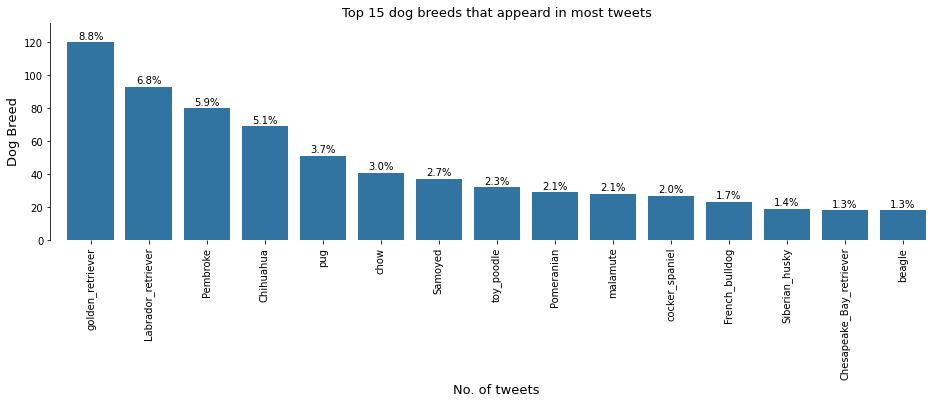

In [54]:
plot_script.create_relative_frequency(data=dog_rates_data, 
                                      column='dog_breed', 
                                      n_subset=15, 
                                      ytick_divider=1, 
                                      ytick_suffix='',
                                      n_ylocatorParams=7)

plt.xlabel('No. of tweets', fontsize=13)
plt.ylabel('Dog Breed', fontsize=13);
plt.title('Top 15 dog breeds that appeard in most tweets', fontsize=13);

From the chart above, We can seen that `golden retriever` were tweeted more than other breeds with about 120 tweets. Other dog breeds that made it to the top include `Labrador retriever, Pembroke, Chihuahua, pug....`

- Among the top most tweeted dogs, Which breed had higher ratings ?

In [55]:
top_15_breeds = dog_rates_data.dog_breed.value_counts()[:15]
id = top_15_breeds.index
#select only top 15 most appeared breeds
most_tweeted = dog_rates_data[dog_rates_data.dog_breed.isin(id)]
most_tweeted.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,retweet_count,favorite_count,dog_breed,rating,dog_stage
6,666055525042405380,2015-11-16 00:49:46+00:00,Here is a Siberian heavily armored polar bear ...,10,10,a,196,367,chow,100.0,None
7,666057090499244032,2015-11-16 00:55:59+00:00,My oh my. This is a rare blond Canadian terrie...,9,10,a,112,247,golden_retriever,90.0,None
9,666063827256086533,2015-11-16 01:22:45+00:00,This is the happiest dog you will ever see. Ve...,10,10,the,180,400,golden_retriever,100.0,None
12,666082916733198337,2015-11-16 02:38:37+00:00,Here we have a well-established sunblockerspan...,6,10,None,37,93,pug,60.0,None
19,666345417576210432,2015-11-16 20:01:42+00:00,Look at this jokester thinking seat belt laws ...,10,10,None,124,244,golden_retriever,100.0,None


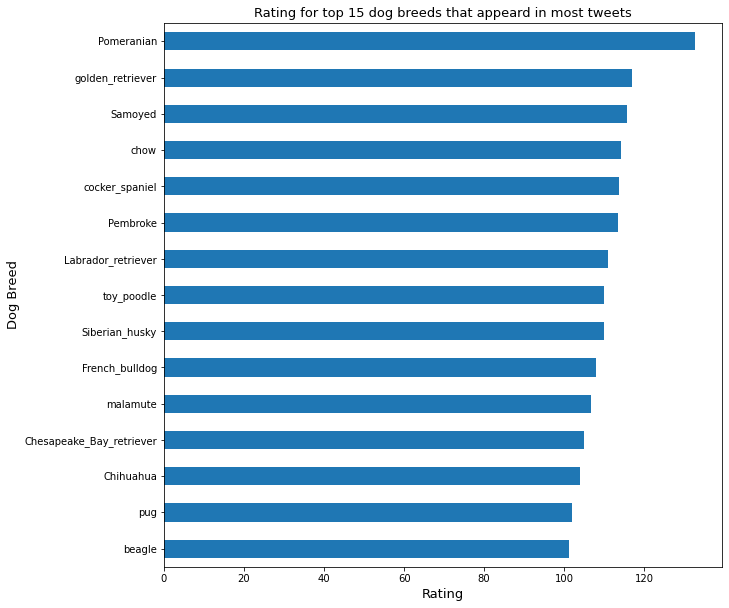

In [56]:
#group by dog_breed and plot
most_tweeted.groupby('dog_breed')['rating'].mean().sort_values() \
            .plot(kind='barh', figsize=(10, 10))

#label plot
plt.xlabel('Rating', fontsize=13)
plt.ylabel('Dog Breed', fontsize=13);
plt.title('Rating for top 15 dog breeds that appeard in most tweets', fontsize=13);

On average, the `Pomernarian` breed had the highest ratings with more than `120%` rating. Also the `golden retriever` which came first among the top tweeted breeds came second. Other top rated breeds includes `Samoyed, chow, cocker spanial, pembroke....`

- Is there a reasonable correlation between number of retweets and number of likes`

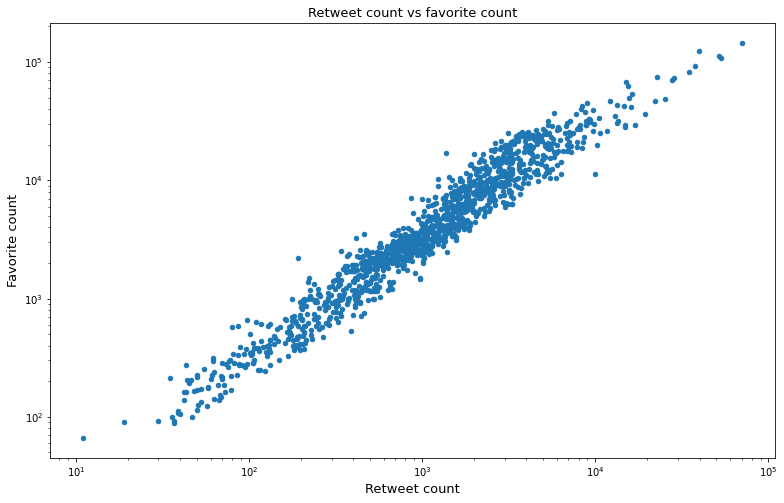

In [57]:
dog_rates_data[['retweet_count', 'favorite_count']] \
            .plot(kind='scatter',
                  x = 'retweet_count',
                  y='favorite_count',
                  figsize=(13, 8), logx=True, logy=True);

#label plot
plt.xlabel('Retweet count', fontsize=13)
plt.ylabel('Favorite count', fontsize=13);
plt.title('Retweet count vs favorite count', fontsize=13);

From the scatter plot above, it's seen that `favorite count` and `retweet count` are highely posetively correlated. This means that tweets that had more retweets also had more likes; and this is a good sanity check